In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
from sklearn.decomposition import PCA
import torch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

### Function to create MFCC coefficients

In [2]:
def create_MFCC_coefficients(file_name):
    sr_value = 44100
    n_mfcc_count = 20
    try:
        y, sr = librosa.load(file_name, sr=sr_value)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        coeff_df = pd.DataFrame(mfccs)
        return coeff_df.T
    except:
        return None

## GTZAN data for pretraining 

In [3]:
L = 2584  
gtzan_Data = []
gtzan_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path, folder))
    for file in file_names:
        file_path = os.path.join(folder_path, folder, file)
        mfcc_data = create_MFCC_coefficients(file_path)
        if mfcc_data is not None:
            delta_mfcc = librosa.feature.delta(mfcc_data)
            delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
            combined_mfcc = np.hstack([mfcc_data, delta_mfcc, delta2_mfcc])
            combined_mfcc_df = pd.DataFrame(combined_mfcc)
            mfcc_data_scaled = scaler.fit_transform(combined_mfcc)
            if len(mfcc_data_scaled) < L:
                padding = L - len(mfcc_data_scaled)
                mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
            elif len(mfcc_data_scaled) > L:
                mfcc_data_scaled = mfcc_data_scaled[:L, :]
            gtzan_Data.append(np.array(mfcc_data_scaled))
            gtzan_Label.append(folder)

/tmp/ipykernel_30/1861942266.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Axes: >

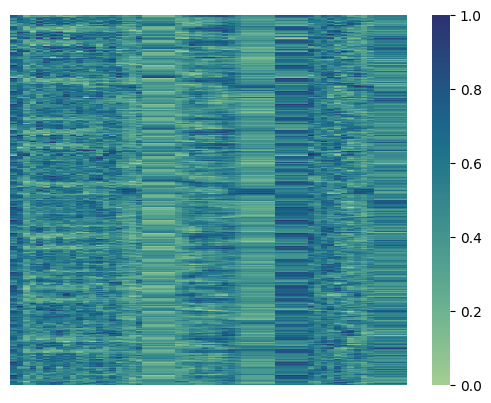

In [4]:
sns.heatmap(gtzan_Data[10],cmap='crest', xticklabels=False, yticklabels=False)

In [5]:
label_encoder = LabelEncoder()
gtzan_Label = label_encoder.fit_transform(gtzan_Label)

In [6]:
def create_sandwiched_vgg19(input_shape=(2584, 60, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Conv2D(3, (3, 3), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.UpSampling2D(size=(8, 8))(x)
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(320, 120, 3))
    base_model.trainable = False
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

model = create_sandwiched_vgg19()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,053,773 (91.76 MB)

 Trainable params: 4,029,389 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
Data = np.array(gtzan_Data)
labels = np.array(gtzan_Label)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [8]:
model.fit(X_train,y_train,epochs = 50,batch_size = 32,validation_split = 0.2)

Epoch 1/50


I0000 00:00:1730600637.304968     115 service.cc:145] XLA service 0x7e0e780014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730600637.305069     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730600657.094268     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0846 - loss: 3.7913 - val_accuracy: 0.1222 - val_loss: 2.2753
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.1136 - loss: 2.3004 - val_accuracy: 0.2222 - val_loss: 2.2059
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.1762 - loss: 2.2084 - val_accuracy: 0.1722 - val_loss: 2.1196
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.2047 - loss: 2.1210 - val_accuracy: 0.2778 - val_loss: 2.0306
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.2499 - loss: 2.0169 - val_accuracy: 0.2167 - val_loss: 2.0987
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.2803 - loss: 1.9096 - val_accuracy: 0.2833 - val_loss: 1.8627
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.3254 - loss: 1.8526 - val_accuracy: 0.2944 - val_loss: 1.8787
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.3106 - loss: 1.8343 - val_accuracy: 0.2500 - val_lo

In [9]:
loss , accuracy = model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.3595 - loss: 3.2311


## Fine tuning on our data

In [10]:
L = 2584  # Target number of frames
Data = []
Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-songs'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    folder__names = os.listdir(os.path.join(folder_path, folder))
    for folder_ in folder__names:
        file_names = os.listdir(os.path.join(folder_path, folder, folder_))
        for file in file_names:
            file_path = os.path.join(folder_path, folder, folder_, file)
            mfcc_data = create_MFCC_coefficients(file_path)
            if mfcc_data is not None:
                delta_mfcc = librosa.feature.delta(mfcc_data)
                delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
                combined_mfcc = np.hstack([mfcc_data, delta_mfcc, delta2_mfcc])
                combined_mfcc_df = pd.DataFrame(combined_mfcc)
                mfcc_data_scaled = scaler.fit_transform(combined_mfcc)
                if len(mfcc_data_scaled) < L:
                    padding = L - len(mfcc_data_scaled)
                    mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
                elif len(mfcc_data_scaled) > L:
                    mfcc_data_scaled = mfcc_data_scaled[:L, :]
                Data.append(np.array(mfcc_data_scaled))
                Label.append(folder_)

In [11]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Label)

In [12]:
Feature_extractor = Model(inputs=model.input,outputs=model.get_layer('dense').output)

In [13]:
x = layers.Dense(6, activation='softmax')(Feature_extractor.output)
fine_tuned_model = Model(inputs=Feature_extractor.input, outputs=x)
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 60, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 60, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2584, 60, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 30, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 30, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 323, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 15, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 40, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 3, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,052,745 (91.75 MB)

 Trainable params: 4,028,361 (15.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
Data = np.array(Data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.05, random_state=42)

In [15]:
fine_tuned_model.fit(X_train,y_train,epochs = 20,batch_size = 32,validation_split = 0.2)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 11s/step - accuracy: 0.0992 - loss: 14.9157 - val_accuracy: 0.2727 - val_loss: 16.7461
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2511 - loss: 17.4261 - val_accuracy: 0.3182 - val_loss: 17.3297
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2158 - loss: 16.1273 - val_accuracy: 0.1364 - val_loss: 13.7811
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2472 - loss: 8.2095 - val_accuracy: 0.1364 - val_loss: 15.1176
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.1418 - loss: 8.9128 - val_accuracy: 0.2273 - val_loss: 9.5305
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2762 - loss: 6.7232 - val_accuracy: 0.3636 - val_loss: 7.1386
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.3133 - loss: 4.8625 - val_accuracy: 0.2273 - val_loss: 5.5906
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.3678 - loss: 3.2339 - val_accuracy: 0.2727 - val

In [16]:
loss , accuracy = model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 4.2513


## Predicting for the given data

In [17]:
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
Data = []
meta_data = []
for file in file_names:
    file_path = os.path.join(folder_path,file)
    meta_data.append(file)
    df = pd.read_csv(file_path,header=None)
    mfcc_data = df.T
    delta_mfcc = librosa.feature.delta(mfcc_data)
    delta2_mfcc = librosa.feature.delta(mfcc_data, order=2)
    combined_mfcc = np.hstack([mfcc_data, delta_mfcc, delta2_mfcc])
    mfcc_data_scaled = pd.DataFrame(scaler.fit_transform(combined_mfcc))
    if len(mfcc_data_scaled) < L:
        padding = L - len(mfcc_data_scaled)
        mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
    elif len(mfcc_data_scaled) > L:
        mfcc_data_scaled = mfcc_data_scaled.iloc[:L, :]
    Data.append(mfcc_data_scaled)
Data = np.array(Data)

In [18]:
predictions = fine_tuned_model.predict(Data)
predicted_labels = predictions.argmax(axis=1)
original_labels = label_encoder.inverse_transform(predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


In [19]:
result_df = pd.DataFrame({'Label': original_labels, 'MetaData': meta_data})
result_df.to_csv('result.csv', index=False)
result_df.head()

,Label,MetaData
0,Asha_Bhosale,70-MFCC.csv
1,Asha_Bhosale,104-MFCC.csv
2,Asha_Bhosale,67-MFCC.csv
3,Asha_Bhosale,110-MFCC.csv
4,Marathi Bhav Geet Songs,92-MFCC.csv


In [20]:
Feature_extractor = Model(inputs=fine_tuned_model.input,outputs=fine_tuned_model.get_layer('dense').output)
e

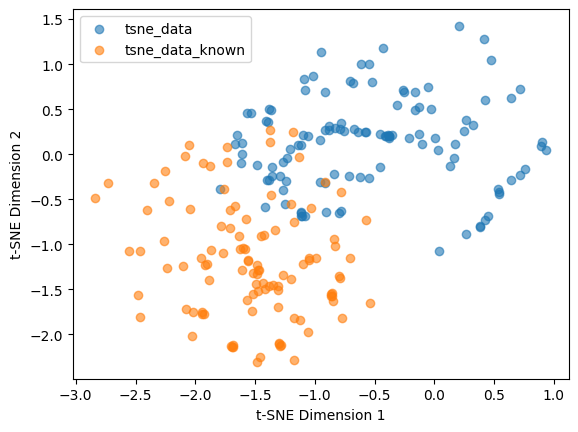

In [29]:
Features = []
for i in range(len(Data)):
    Features.append(Feature_extractor(Data[i].reshape(1,2584,60,1))[0])
Features_known = []
for i in range(len(X_train)):
    Features_known.append(Feature_extractor(X_train[i].reshape(1,2584,60,1))[0])
Features = np.array(Features)
Features_known = np.array(Features_known)
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(Features)
tsne_data_known = model.fit_transform(Features_known)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label="tsne_data", alpha=0.6)
plt.scatter(tsne_data_known[:, 0], tsne_data_known[:, 1], label="tsne_data_known", alpha=0.6)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

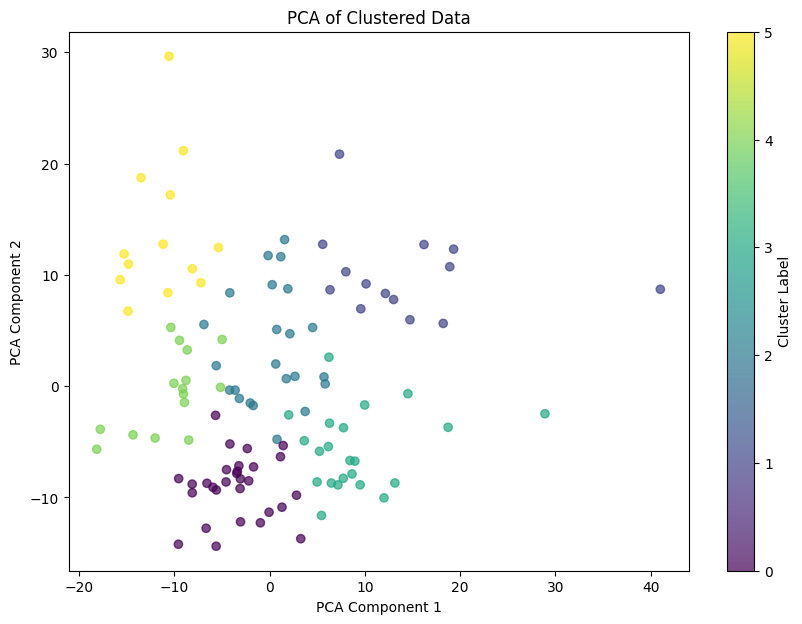

In [38]:
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(Features)
Cluster_label = kmeans.labels_
pca = PCA(n_components=2)
features_pca = pca.fit_transform(Features)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=Cluster_label, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")  # Color bar to show cluster label mapping
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Clustered Data")
plt.show()

In [39]:
result_df = pd.DataFrame({'CLuster_Label': Cluster_label, 'MetaData': meta_data})
result_df.to_csv('Cluster.csv', index=False)
result_df.head()

,CLuster_Label,MetaData
0,2,70-MFCC.csv
1,3,104-MFCC.csv
2,2,67-MFCC.csv
3,5,110-MFCC.csv
4,4,92-MFCC.csv
